In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms
from sklearn.metrics import jaccard_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [3]:
train_df = pd.read_pickle(r'C:\Users\Salem\Desktop\Pytorch Final Project\Data\lung_cancer_train.pkl')
test_df = pd.read_pickle(r'C:\Users\Salem\Desktop\Pytorch Final Project\Data\lung_cancer_test.pkl')

In [5]:
# with open(r'C:\Users\Salem\Desktop\Pytorch Final Project\Data\lung_cancer_train.pkl', 'rb') as f:
#     train_df = pickle.load(f)
# with open(r'C:\Users\Salem\Desktop\Pytorch Final Project\Data\lung_cancer_test.pkl', 'rb') as f:
#     test_df = pickle.load(f)


In [5]:
train_df.head()

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."


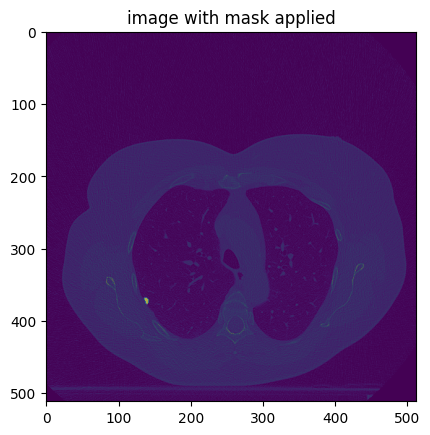

In [6]:
img = train_df['hu_array_old'][0]
mask = train_df['mask'][0]
plt.imshow(img)
plt.imshow(mask, alpha = 0.6)
plt.title("image with mask applied")
plt.show()

In [9]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __getitem__(self, index):
        image = self.images[index]  # Directly access the NumPy array
        image = np.asarray(image).astype(float)#.reshape(512, 512, 1)

        mask = self.masks[index]
        mask = np.asarray(mask).astype(float)#.reshape(512, 512, 1)

        transformed_image = self.transforms(image)
        return transformed_image, mask

    def __len__(self):
        return len(self.images)

transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_images = (train_df['hu_array_old'].values)
train_masks = (train_df['mask'].values)
test_images = (test_df['hu_array_old'].values)
test_masks = (test_df['mask'].values)

train_data = CustomDataset(train_images, train_masks, transform)
trainloader = DataLoader(train_data, batch_size=75, shuffle=False)

test_data = CustomDataset(test_images, test_masks, transform)
testloader = DataLoader(test_data, batch_size=75, shuffle=False)


In [8]:
# import segmentation_models_pytorch as smp

# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights="imagenet",
#     in_channels=1,  
#     classes=2,  
# )
# #Trying another prebuilt unet that didn't really pan out

Epoch 1: Train Loss = 0.2072, Val Loss = 0.1748, Accuracy = 71.91, IoU = 0.0017%
Epoch 2: Train Loss = 0.3453, Val Loss = 0.1198, Accuracy = 81.91, IoU = 0.0035%
Epoch 3: Train Loss = 0.4422, Val Loss = 0.0846, Accuracy = 87.31, IoU = 0.0053%
Epoch 4: Train Loss = 0.5123, Val Loss = 0.0600, Accuracy = 91.91, IoU = 0.0064%
Epoch 5: Train Loss = 0.5637, Val Loss = 0.0424, Accuracy = 99.38, IoU = 0.0071%
Epoch 6: Train Loss = 0.6021, Val Loss = 0.0304, Accuracy = 99.89, IoU = 0.0077%
Epoch 7: Train Loss = 0.6315, Val Loss = 0.0225, Accuracy = 99.91, IoU = 0.0078%
Epoch 8: Train Loss = 0.6548, Val Loss = 0.0173, Accuracy = 99.91, IoU = 0.0078%
Epoch 9: Train Loss = 0.6739, Val Loss = 0.0137, Accuracy = 99.91, IoU = 0.0078%
Epoch 10: Train Loss = 0.6901, Val Loss = 0.0113, Accuracy = 99.91, IoU = 0.0078%


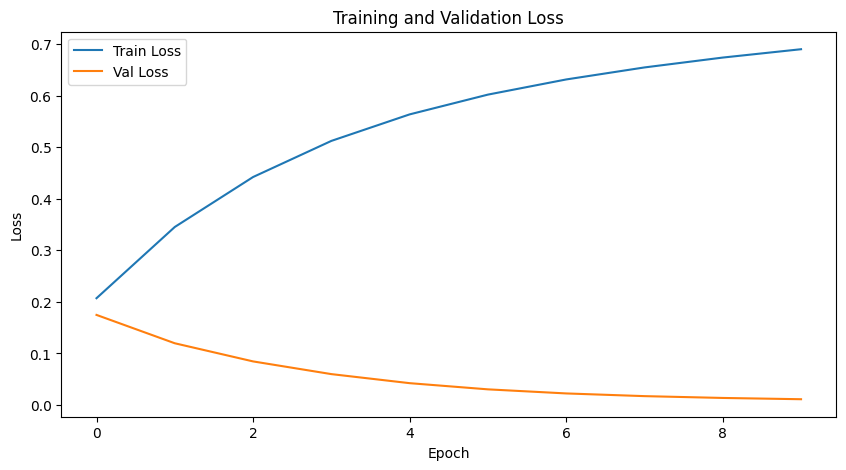

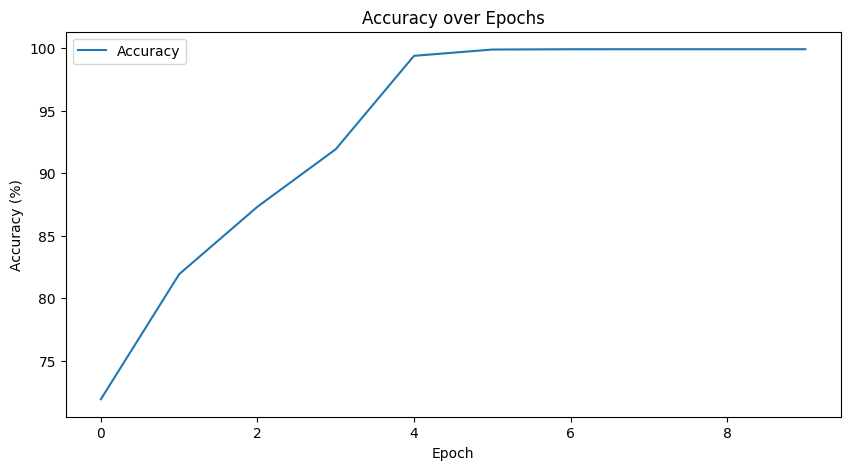

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid activation for binary segmentation
        )

    def forward(self, x):
        # Encoder forward pass
        x_enc = self.encoder(x)
        
        # Decoder forward pass
        x_dec = self.decoder(x_enc)
        
        
        return x_dec


in_channels = 1 
out_channels = 1 
model = UNet(in_channels, out_channels)

#loss function and optimizer
criterion = nn.MSELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
total_loss = 0
total_iou = 0

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
accuracies = []

# Training loop 
for epoch in range(num_epochs):
    for batch in trainloader:
        inputs, masks = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.float()
        masks = masks.float()
        outputs = outputs.squeeze(1)

        # Convert predictions to binary (0 or 1)
        predicted_masks = (outputs > 0.5).float()
        
        # Calculate loss
        loss = criterion(outputs, masks)
        total_loss += loss.item()
        
        #Calculate IoU
        iou = jaccard_score(masks.view(-1), predicted_masks.view(-1))
        total_iou += iou

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(trainloader)
    avg_iou = total_iou / len(trainloader) #iou doesn't change but that is to be expected
    
    #print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")#, IoU = {avg_iou:.4f}")
        
        
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for val_batch in testloader:
            val_inputs, val_masks = val_batch
            val_outputs = model(val_inputs)
            val_outputs = val_outputs.float()
            val_masks = val_masks.float()
            val_outputs = val_outputs.squeeze(1)

            # Convert predictions to binary (0 or 1)
            val_predicted_masks = (val_outputs > 0.5).float()

            # Calculate validation loss
            val_loss = criterion(val_outputs, val_masks)
            total_val_loss += val_loss.item()

            # Calculate accuracy
            correct_pixels += (val_predicted_masks == val_masks).sum().item()
            total_pixels += val_masks.numel()
    
    avg_val_loss = total_val_loss / len(testloader)
    accuracy = 100.0 * correct_pixels / total_pixels
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Accuracy = {accuracy:.2f}, IoU = {avg_iou:.4f}%")

    # Append loss and accuracy values
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    accuracies.append(accuracy)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()
            


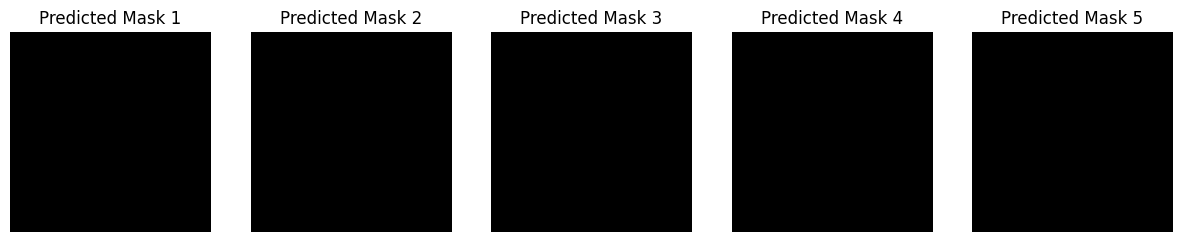

In [11]:
# Assuming you have a batch of predicted masks (val_predicted_masks)
# Convert them to grayscale images
predicted_images = (val_predicted_masks * 255).numpy().astype(np.uint8)

# Display a few predicted images
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    ax = axes[i]
    ax.imshow(predicted_images[i], cmap='gray')
    ax.set_title(f"Predicted Mask {i+1}")
    ax.axis('off')

plt.show()